In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
df = pd.read_csv('Bitcoin Candlesticks 2019-2023.csv')

In [4]:
print(df.head())

       timestamp     open    close     high      low        volume
0  1569196800000  9930.13  9930.13  9930.13  9930.13  9.930130e+00
1  1569283200000  9637.93  8519.67  9665.05  7996.45  1.739432e+06
2  1569369600000  8528.12  8435.28  8724.77  8247.78  4.693617e+05
3  1569456000000  8434.45  8064.41  8453.20  7761.87  3.409237e+05
4  1569542400000  8078.75  8178.73  8259.96  7858.58  3.799180e+05


In [5]:
bitcoin_prices= df[["timestamp", "high"]]
print(bitcoin_prices.head())

       timestamp     high
0  1569196800000  9930.13
1  1569283200000  9665.05
2  1569369600000  8724.77
3  1569456000000  8453.20
4  1569542400000  8259.96


In [6]:
bitcoin_prices["time"] = pd.to_datetime(bitcoin_prices["timestamp"], unit='ms')
print(bitcoin_prices.head())

       timestamp     high       time
0  1569196800000  9930.13 2019-09-23
1  1569283200000  9665.05 2019-09-24
2  1569369600000  8724.77 2019-09-25
3  1569456000000  8453.20 2019-09-26
4  1569542400000  8259.96 2019-09-27


/var/folders/2t/2y0f_lxd6w3806pjj2pppbx80000gn/T/ipykernel_40638/3323104723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_prices["time"] = pd.to_datetime(bitcoin_prices["timestamp"], unit='ms')


In [7]:
bitcoin_prices_2023_and_after = bitcoin_prices[bitcoin_prices["time"].dt.year >= 2023]
print(bitcoin_prices_2023_and_after.head())
bitcoin_prices_2022_and_before = bitcoin_prices[bitcoin_prices["time"].dt.year < 2023]
print(bitcoin_prices_2022_and_before.head())

          timestamp      high       time
1196  1672531200000  16628.20 2023-01-01
1197  1672617600000  16785.92 2023-01-02
1198  1672704000000  16774.53 2023-01-03
1199  1672790400000  16984.83 2023-01-04
1200  1672876800000  16878.61 2023-01-05
       timestamp     high       time
0  1569196800000  9930.13 2019-09-23
1  1569283200000  9665.05 2019-09-24
2  1569369600000  8724.77 2019-09-25
3  1569456000000  8453.20 2019-09-26
4  1569542400000  8259.96 2019-09-27


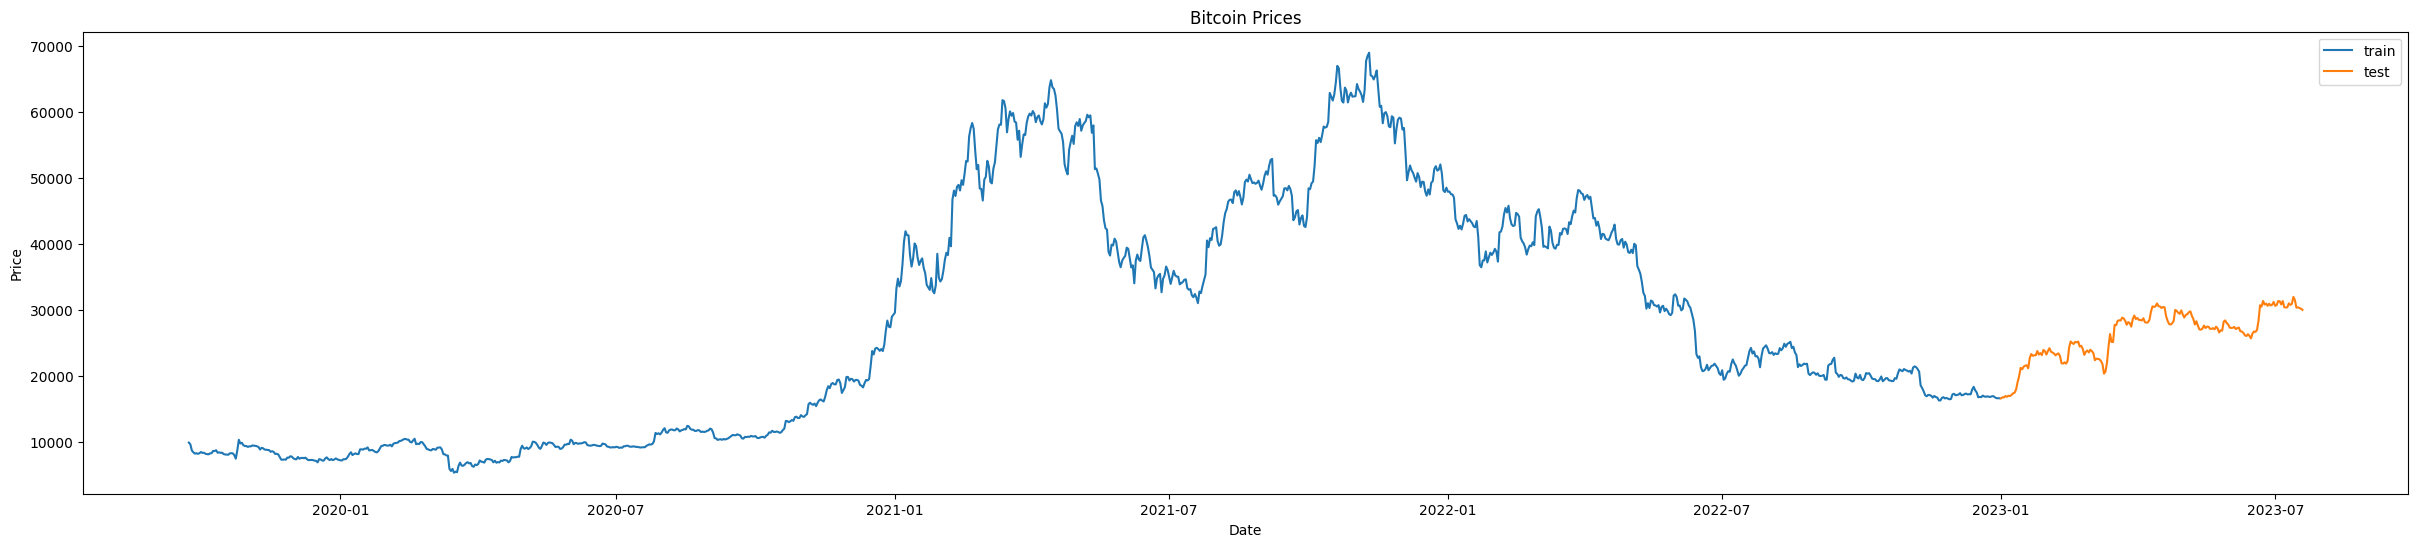

In [13]:
X_train = bitcoin_prices_2022_and_before["timestamp"]
X_train_time = bitcoin_prices_2022_and_before["time"]
y_train = bitcoin_prices_2022_and_before["high"]

X_test = bitcoin_prices_2023_and_after["timestamp"]
X_test_time = bitcoin_prices_2023_and_after["time"]
y_test = bitcoin_prices_2023_and_after["high"]

fig, ax = plt.subplots(figsize=(30, 6))

ax.plot(X_train_time, y_train, label="train")
ax.plot(X_test_time, y_test, label='test')
ax.set_title("Bitcoin Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()

plt.show()


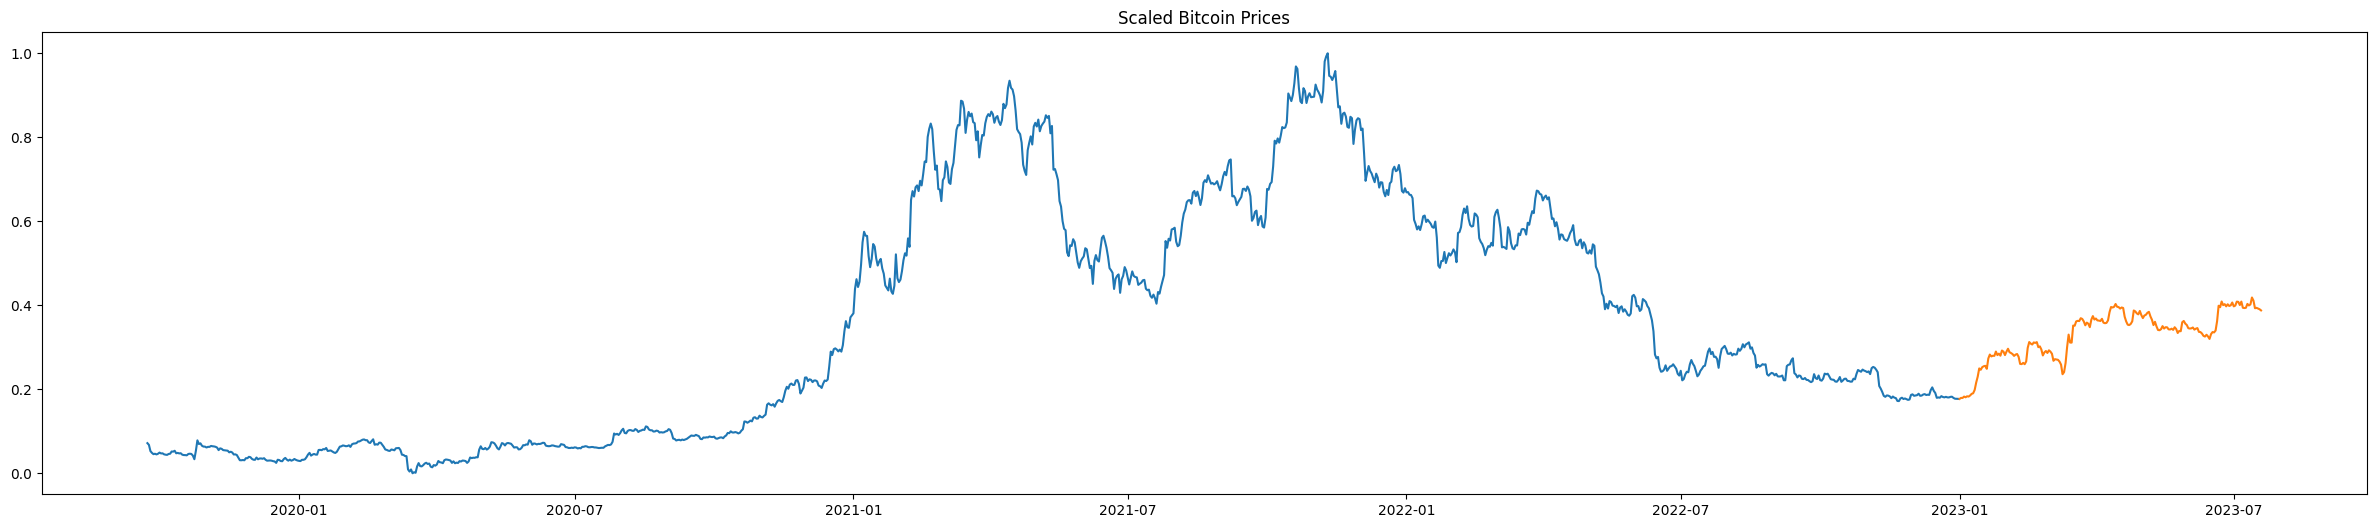

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.values.reshape(-1, 1))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(30, 6))

ax.plot(X_train_time, y_train_scaled)
ax.plot(X_test_time, y_test_scaled)
ax.set_title("Scaled Bitcoin Prices")
plt.show()



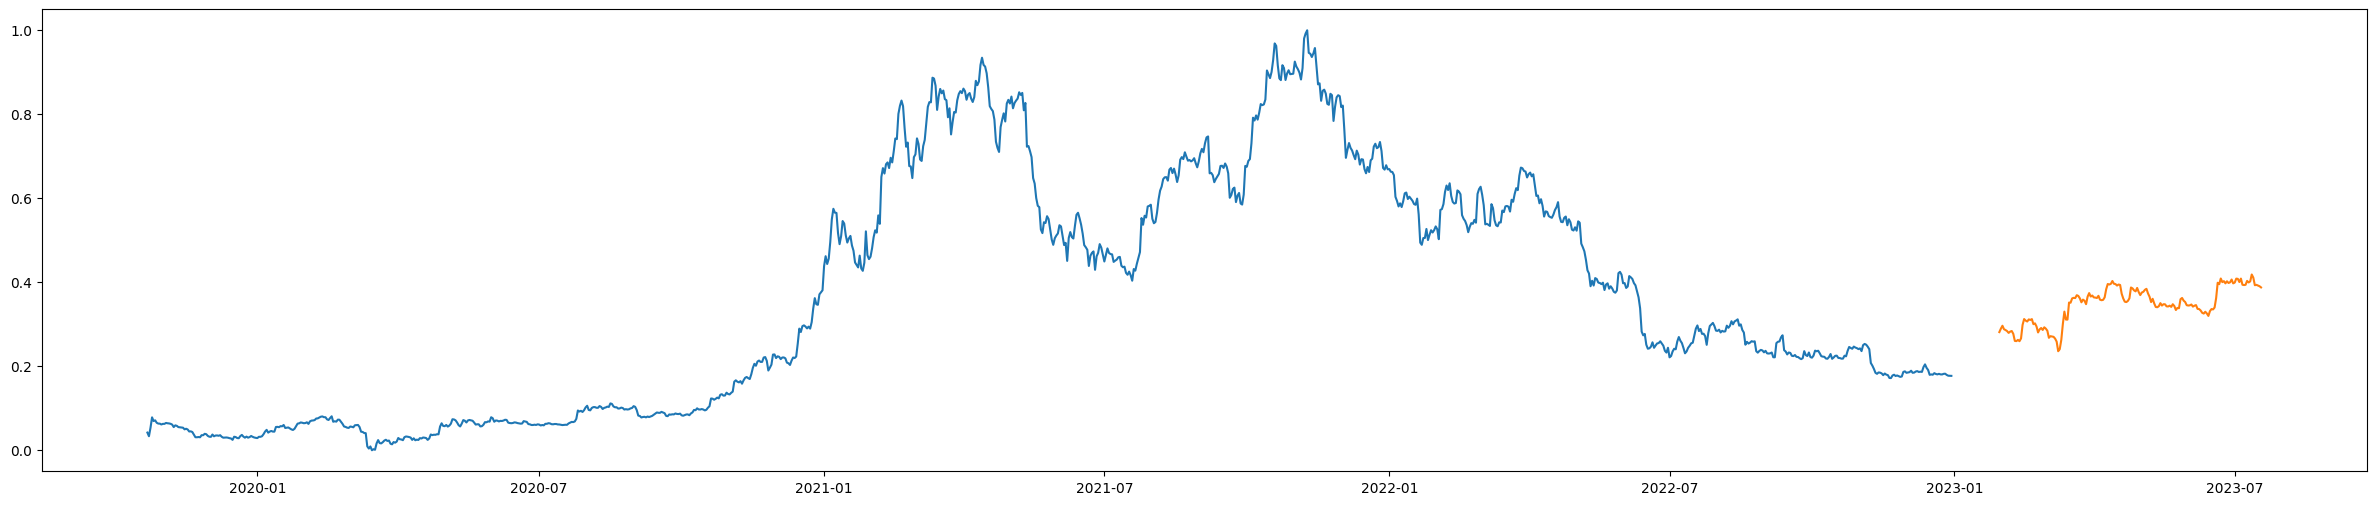

In [10]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 30  # Length of the sequence

X_train_seq, y_train_seq = create_sequences(y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(y_test_scaled, seq_length)

fig, ax = plt.subplots(figsize=(30, 6))

ax.plot(X_train_time[29:-1], y_train_seq)
ax.plot(X_test_time[29:-1], y_test_seq)
plt.show()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_seq, y_train_seq, epochs=40, batch_size=100,  validation_data=(X_test_seq, y_test_seq))

Epoch 1/40
12/12 [==============================] - 1s 50ms/step - loss: 0.0937 - val_loss: 0.0185
Epoch 2/40
12/12 [==============================] - 1s 43ms/step - loss: 0.0173 - val_loss: 0.0020
Epoch 3/40
12/12 [==============================] - 0s 41ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 4/40
12/12 [==============================] - 1s 42ms/step - loss: 0.0051 - val_loss: 7.5500e-04
Epoch 5/40
12/12 [==============================] - 0s 42ms/step - loss: 0.0047 - val_loss: 5.6218e-04
Epoch 6/40
12/12 [==============================] - 0s 41ms/step - loss: 0.0040 - val_loss: 6.0719e-04
Epoch 7/40
12/12 [==============================] - 0s 41ms/step - loss: 0.0039 - val_loss: 6.3526e-04
Epoch 8/40
12/12 [==============================] - 1s 43ms/step - loss: 0.0041 - val_loss: 5.6371e-04
Epoch 9/40
12/12 [==============================] - 1s 45ms/step - loss: 0.0038 - val_loss: 5.6396e-04
Epoch 10/40
12/12 [==============================] - 1s 45ms/step - loss: 0.0039 - va

6/6 [==============================] - 0s 6ms/step


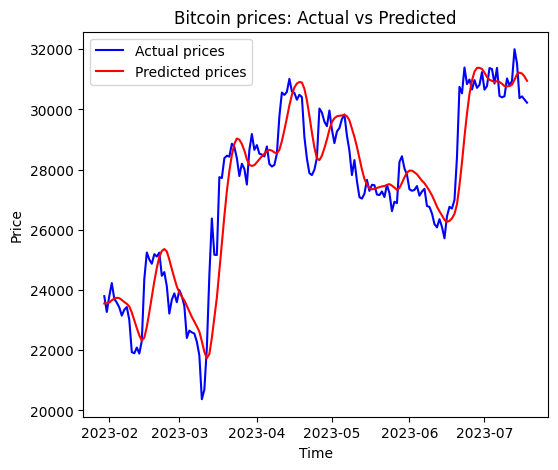

1225   2023-01-30
1226   2023-01-31
1227   2023-02-01
1228   2023-02-02
1229   2023-02-03
          ...    
1390   2023-07-14
1391   2023-07-15
1392   2023-07-16
1393   2023-07-17
1394   2023-07-18
Name: time, Length: 170, dtype: datetime64[ns]


In [20]:
# Predict the prices
y_pred = model.predict(X_test_seq)

# Rescale the data back to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot actual vs predicted prices
plt.figure(figsize=(6, 5))
plt.plot(X_test_time[29:-1], y_test[29:-1],  color='blue', label='Actual prices')
plt.plot(X_test_time[29:-1], y_pred_rescaled.flatten(), color='red', label='Predicted prices')
plt.title('Bitcoin prices: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
print(X_test_time[29:-1])